In [1]:
import sqlite3 as sql
import pandas as pd
import requests
import json
import prettytable
import bls
import os
import re

In [2]:
api_key = '5fdea5fc6e05421c82c71ccbe827486e'

Useful Dictionary:

In [3]:
states = [
    ("Alabama", "AL"), ("Alaska", "AK"), ("Arizona", "AZ"), ("Arkansas", "AR"), ("California", "CA"), ("Colorado", "CO"),
    ("Connecticut", "CT"), ("Delaware", "DE"), ("District of Columbia", "DC"), ("Florida", "FL"), ("Georgia", "GA"),
    ("Hawaii", "HI"), ("Idaho", "ID"), ("Illinois", "IL"), ("Indiana", "IN"), ("Iowa", "IA"), ("Kansas", "KS"),
    ("Kentucky", "KY"), ("Louisiana", "LA"), ("Maine", "ME"), ("Maryland", "MD"), ("Massachusetts", "MA"),
    ("Michigan", "MI"), ("Minnesota", "MN"), ("Mississippi", "MS"), ("Missouri", "MO"), ("Montana", "MT"),
    ("Nebraska", "NE"), ("Nevada", "NV"), ("New Hampshire", "NH"), ("New Jersey", "NJ"), ("New Mexico", "NM"),
    ("New York", "NY"), ("North Carolina", "NC"), ("North Dakota", "ND"), ("Ohio", "OH"), ("Oklahoma", "OK"),
    ("Oregon", "OR"), ("Pennsylvania", "PA"), ("Rhode Island", "RI"), ("South Carolina", "SC"), ("South Dakota", "SD"),
    ("Tennessee", "TN"), ("Texas", "TX"), ("Utah", "UT"), ("Vermont", "VT"), ("Virginia", "VA"), ("Washington", "WA"),
    ("West Virginia", "WV"), ("Wisconsin", "WI"), ("Wyoming", "WY")
]

# Sort the states alphabetically by their full names
states.sort(key=lambda x: x[0])

# Indices to skip
skip_indices = {3, 7, 14, 43, 52}

# Create the dictionary
state_dict = {}
index = 1
for full_name, abbreviation in states:
    while index in skip_indices:
        index += 1
    state_dict[index] = abbreviation
    index += 1

## Downloading txt files

In [ ]:
def download_bls_table(url, output_dir="bls_data", filename=None):
    """
    Downloads a BLS table from a given URL and saves it as a text file.

    Args:
        url: The URL of the BLS table (text file).
        output_dir: The directory to save the downloaded file.
        filename: (Optional) Custom filename. If None, uses the filename from the URL.

    Returns:
        The full path to the saved file, or None if an error occurred.
    """

    try:
        # Create the output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36'}
        # Fetch the file content
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)

        # Determine the filename
        if filename is None:
            # Extract filename from URL
            filename = os.path.basename(url)
            # Further improve the filename: remove any query parameters, etc.
            filename = filename.split('?')[0] # remove query parameters, if any

        # Ensure a .txt extension (or appropriate for the content)
        if not filename.lower().endswith(('.txt', '.csv', '.dat')):  # Add other likely extensions
             filename += '.txt' # Append .txt if no suitable extension is found


        # Construct the full file path
        file_path = os.path.join(output_dir, filename)

        # Save the file content
        with open(file_path, 'w', encoding='utf-8') as f:  # Use UTF-8 encoding
            f.write(response.text)

        print(f"Downloaded and saved to: {file_path}")
        return file_path

    except requests.exceptions.RequestException as e:
        print(f"Error downloading from {url}: {e}")
        return None
    except OSError as e:
        print(f"Error saving file: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

Downloaded and saved to: bls_data/al_age_total_table7.txt
  Table 7. Survival of private sector establishments by opening year
0                                      Total Private                
1                                            Alabama                
2                            Surviving       Tota...                
3                            Establishments  of S...                
4                                                ...                


In [ ]:
def parse_survival_text_file(
        file_path: str,
        ) -> pd.DataFrame:
    """
    Parses BLS text file on business survival data and extracts relevant data into a DataFrame.

    Args:
        file_path (str): The path to the text file to be parsed.

    Returns:
        pd.DataFrame: A DataFrame containing the parsed data with columns:
            'Year Established', 'Year', 'Surviving Establishments', 
            'Total Employment of Survivors', 'Survival Rates Since Birth', 
            'Survival Rates of Previous Year's Survivors', 'Average Employment of Survivors'.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    current_year = None

    for line in lines:
        # Check for the "Annual openings Year ended:" line to get the current year
        year_match = re.match(r'Year ended: March (\d{4})', line)
        if year_match:
            current_year = year_match.group(1)
            continue

        # Skip lines that do not contain data
        if not re.match(r'\s*March \d{4}', line):
            continue

        # Extract data from the line
        columns = re.split(r'\s{2,}', line.strip())
        if len(columns) == 6:
            columns.insert(0, current_year)  # Insert the current year at the beginning
            columns[1] = columns[1][-4:]
            data.append(columns)

    # Create a DataFrame from the parsed data
    df = pd.DataFrame(data, columns=[
        'Year Established', 'Year', 'Surviving Establishments', 'Total Employment of Survivors',
        'Survival Rates Since Birth', 'Survival Rates of Previous Year\'s Survivors',
        'Average Employment of Survivors'
    ])

    return df

    Year Established  Year Surviving Establishments  \
0               1994  1994                    9,260   
1               1994  1995                    7,275   
2               1994  1996                    6,293   
3               1994  1997                    5,630   
4               1994  1998                    5,137   
..               ...   ...                      ...   
491             2022  2023                    9,464   
492             2022  2024                    8,205   
493             2023  2023                   16,012   
494             2023  2024                   12,366   
495             2024  2024                   13,249   

    Total Employment of Survivors Survival Rates Since Birth  \
0                          68,797                      100.0   
1                          65,993                       78.6   
2                          63,045                       68.0   
3                          60,887                       60.8   
4                  

In [ ]:
survival_data = []
for state in state_dict.values():
    single_url = f"https://www.bls.gov/bdm/{state.lower()}_age_total_table7.txt"  # Survival Data
    file_path = download_bls_table(single_url)
    state_df = parse_survival_text_file(file_path)
    state_df['State'] = state
    survival_data.append(state_df)

survival_data_total = pd.concat(survival_data)

Downloaded and saved to: bls_data/al_age_total_table7.txt
Downloaded and saved to: bls_data/ak_age_total_table7.txt
Downloaded and saved to: bls_data/az_age_total_table7.txt
Downloaded and saved to: bls_data/ar_age_total_table7.txt
Downloaded and saved to: bls_data/ca_age_total_table7.txt
Downloaded and saved to: bls_data/co_age_total_table7.txt
Downloaded and saved to: bls_data/ct_age_total_table7.txt
Downloaded and saved to: bls_data/de_age_total_table7.txt
Downloaded and saved to: bls_data/dc_age_total_table7.txt
Downloaded and saved to: bls_data/fl_age_total_table7.txt
Downloaded and saved to: bls_data/ga_age_total_table7.txt
Downloaded and saved to: bls_data/hi_age_total_table7.txt
Downloaded and saved to: bls_data/id_age_total_table7.txt
Downloaded and saved to: bls_data/il_age_total_table7.txt
Downloaded and saved to: bls_data/in_age_total_table7.txt
Downloaded and saved to: bls_data/ia_age_total_table7.txt
Downloaded and saved to: bls_data/ks_age_total_table7.txt
Downloaded and

In [138]:
# Save the dataframe to the SQLite database
conn = sql.connect("states.db")
survival_data_total.to_sql("survival_rates", conn, if_exists="replace", index=False)

25296

## Downloading Series files through API

In [77]:
def get_yearly_averaged_value(
        series: pd.DataFrame
        ) -> pd.DataFrame:
    '''
    Calculate the yearly averaged values from a given time series dataframe.
    
    Parameters:
    series (pd.DataFrame): A dataframe containing the time series data.
    
    Returns:
    pd.DataFrame: A dataframe with the yearly averaged values.
    '''
    # Resample the data to yearly frequency and calculate the mean for each year
    df_yearly = series.resample('Y').mean()
    
    # Rename the index to 'Year' for clarity
    df_yearly.index.name = 'Year'
    
    return df_yearly

In [ ]:
def get_series_data_by_state(
        start_year: int,
        end_year: int
        ) -> list[pd.DataFrame]:
    """
    Fetches and processes unemployment rate data for each state from the BLS API.

    Args:
        start_year (int): The starting year for the data.
        end_year (int): The ending year for the data.

    Returns:
        list: A list of DataFrames, each containing the yearly averaged unemployment rate data for a state.
    """
    state_unemployment_rates = []
    for i in range(1, 57):
        if (i != 3) & (i != 7) & (i != 14) & (i != 43) & (i != 52):
            print(i)
            state_id = str(i).zfill(2)
            series_name = f'LASST{state_id}0000000000003'
            df = bls.get_series(series_name, start_year, end_year, api_key)
            yearly_data = get_yearly_averaged_value(df).to_frame().reset_index()
            state = state_dict[i]
            yearly_data['State'] = state
            yearly_data.rename(columns={series_name: 'Unemployment Rate'}, inplace=True)
            state_unemployment_rates.append(yearly_data)
    return state_unemployment_rates
    

In [104]:
time_spent_socializing_2019 = bls.get_series('TUU10101AA01014236', 2003, 2019, api_key)
time_spent_socializing_2021 = bls.get_series('TUU10101AA01014236', 2021, 2023, api_key)
time_spent_socializing = pd.concat((time_spent_socializing_2019, time_spent_socializing_2021))

In [ ]:
state_unemployment_rates = get_series_data_by_state(1994, 2024)
state_unemployment_rates_df = pd.concat(state_unemployment_rates)
state_unemployment_rates_df['Year'] = state_unemployment_rates_df['Year'].astype(str) # Convert year to string for sqlite

1
2
4
5
6
8
9
10
11
12
13
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
44
45
46
47
48
49
50
51
53
54
55
56


Save to SQL db

In [49]:
# Save the dataframe to the SQLite database
conn = sql.connect("states.db")
state_unemployment_rates_df.to_sql("unemployment_rate", conn, if_exists="replace", index=False)
conn.close()

NameError: name 'state_unemployment_rates_df' is not defined

## Visualizations

In [72]:
conn = sql.connect("states.db")
survival = pd.read_sql_query("SELECT * FROM survival_rates", conn)
unemployment = pd.read_sql_query("SELECT * FROM unemployment_rate", conn)
conn.close()

survival["Year"] = survival["Year"].astype(int)
survival["Year Established"] = survival["Year Established"].astype(int)

# Remove commas and convert the remaining columns to float
columns_to_convert = survival.columns.difference(['State', 'Year', 'Year Established'])
survival[columns_to_convert] = survival[columns_to_convert].replace({',': ''}, regex=True).apply(pd.to_numeric, errors='coerce')

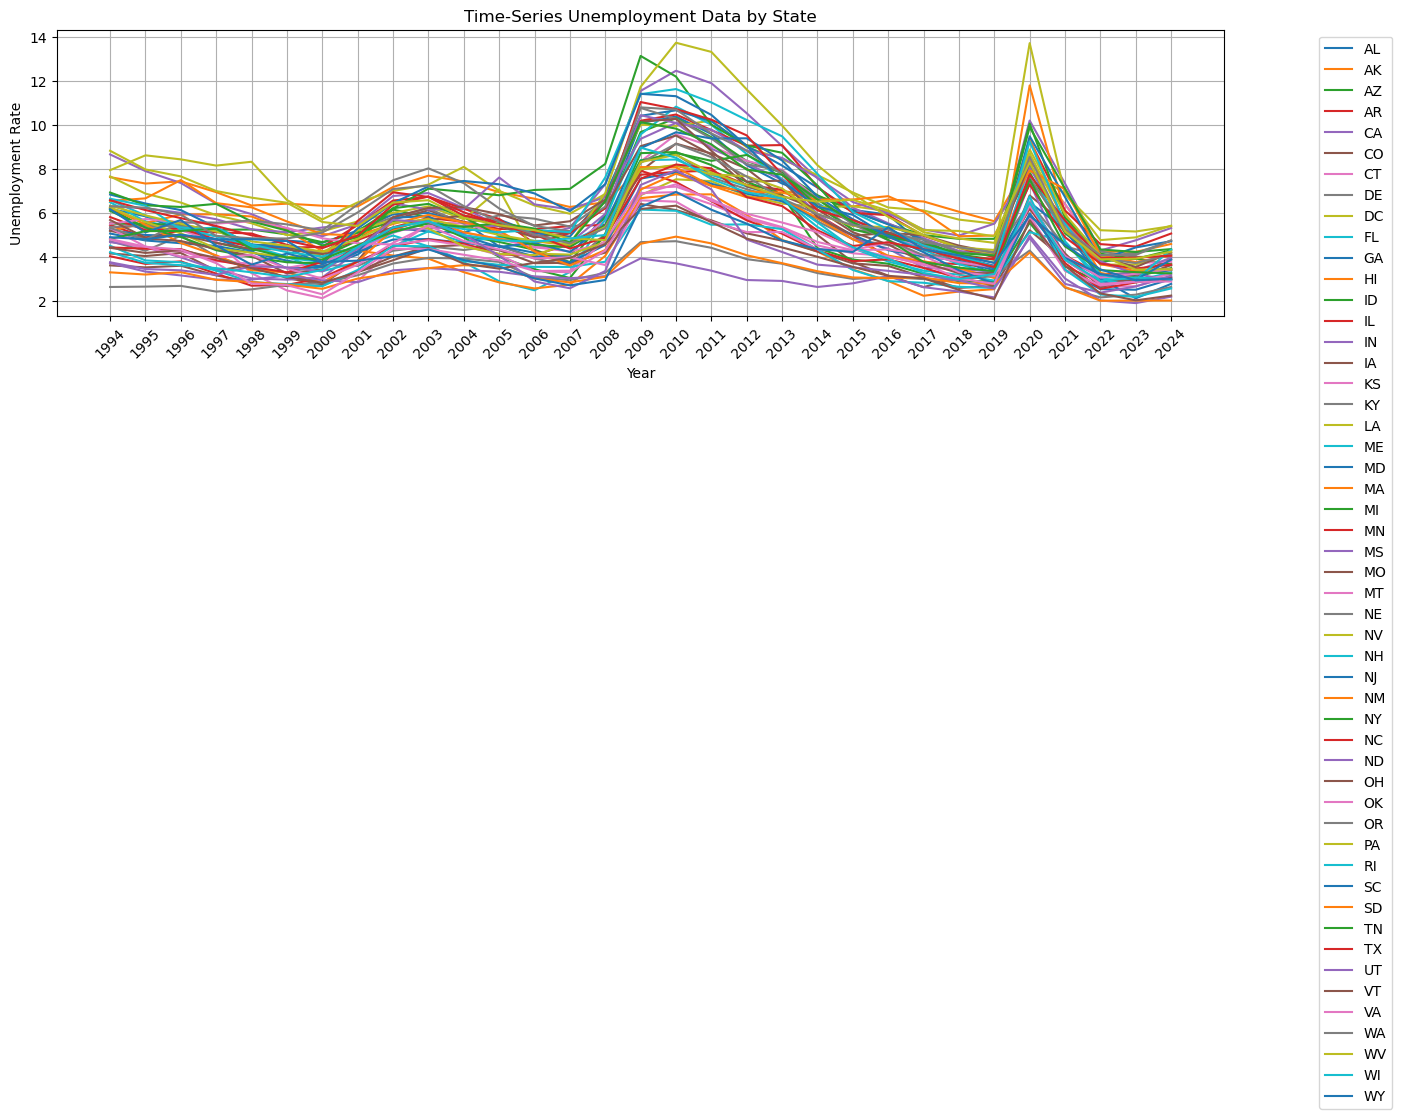

In [75]:
import matplotlib.pyplot as plt

# Plot the time-series unemployment data by state
plt.figure(figsize=(14, 8))

for state in unemployment['State'].unique():
    state_data = unemployment[unemployment['State'] == state]
    plt.plot(state_data['Year'].astype(str), state_data['Unemployment Rate'], label=state)

plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.title('Time-Series Unemployment Data by State')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [107]:
df_filtered = survival[survival["Year Established"] != survival["Year"]]
df_filtered = df_filtered[df_filtered["Year Established"] != df_filtered["Year"] - 1]
survival_rates_grouped_state = df_filtered.groupby(["State", "Year"]).apply(
    lambda x: (x["Survival Rates of Previous Year's Survivors"] * x["Surviving Establishments"]).sum() / x["Surviving Establishments"].sum()
)
survival_rates_grouped_nationwide = df_filtered.groupby(["Year"]).apply(
    lambda x: (x["Survival Rates of Previous Year's Survivors"] * x["Surviving Establishments"]).sum() / x["Surviving Establishments"].sum()
)

Now we can choose a state for unemployment data and survival rate data:

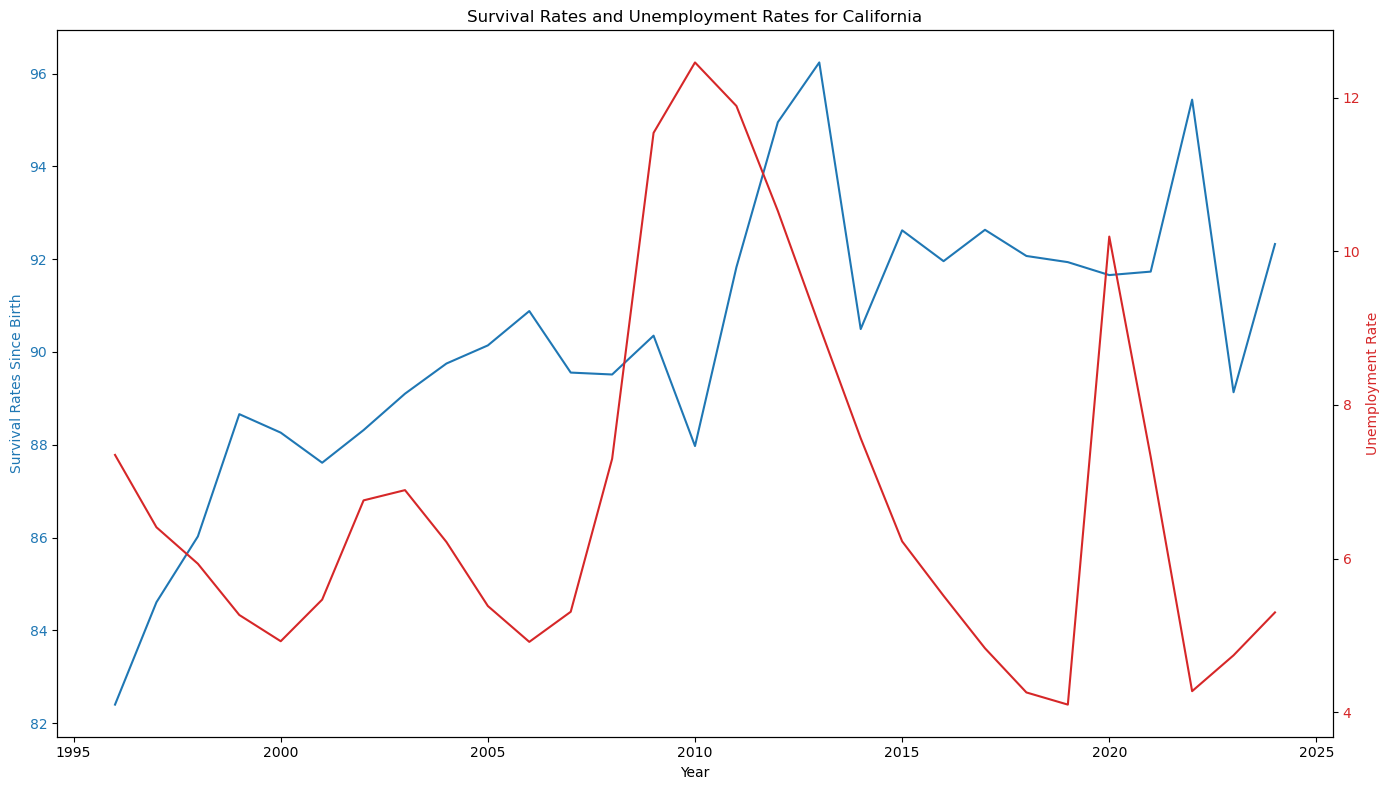

In [ ]:
import matplotlib.pyplot as plt

# Filter the data for Arizona
survival_rates_az = survival_rates_grouped_state["CA"]
unemployment_az = unemployment[(unemployment["State"] == "CA") & (unemployment["Year"].astype(int) > 1995)]
years = survival_rates_az.index.get_level_values('Year')

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the survival rates on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Survival Rates Since Birth', color=color)
ax1.plot(years, survival_rates_az.values, color=color, label='Survival Rates of Last Year\'s Surviving Businesses')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for the unemployment rates
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Unemployment Rate', color=color)
ax2.plot(years, unemployment_az['Unemployment Rate'], color=color, label='Unemployment Rate')
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and show the plot
plt.title('Survival Rates and Unemployment Rates for California')
fig.tight_layout()
plt.show()


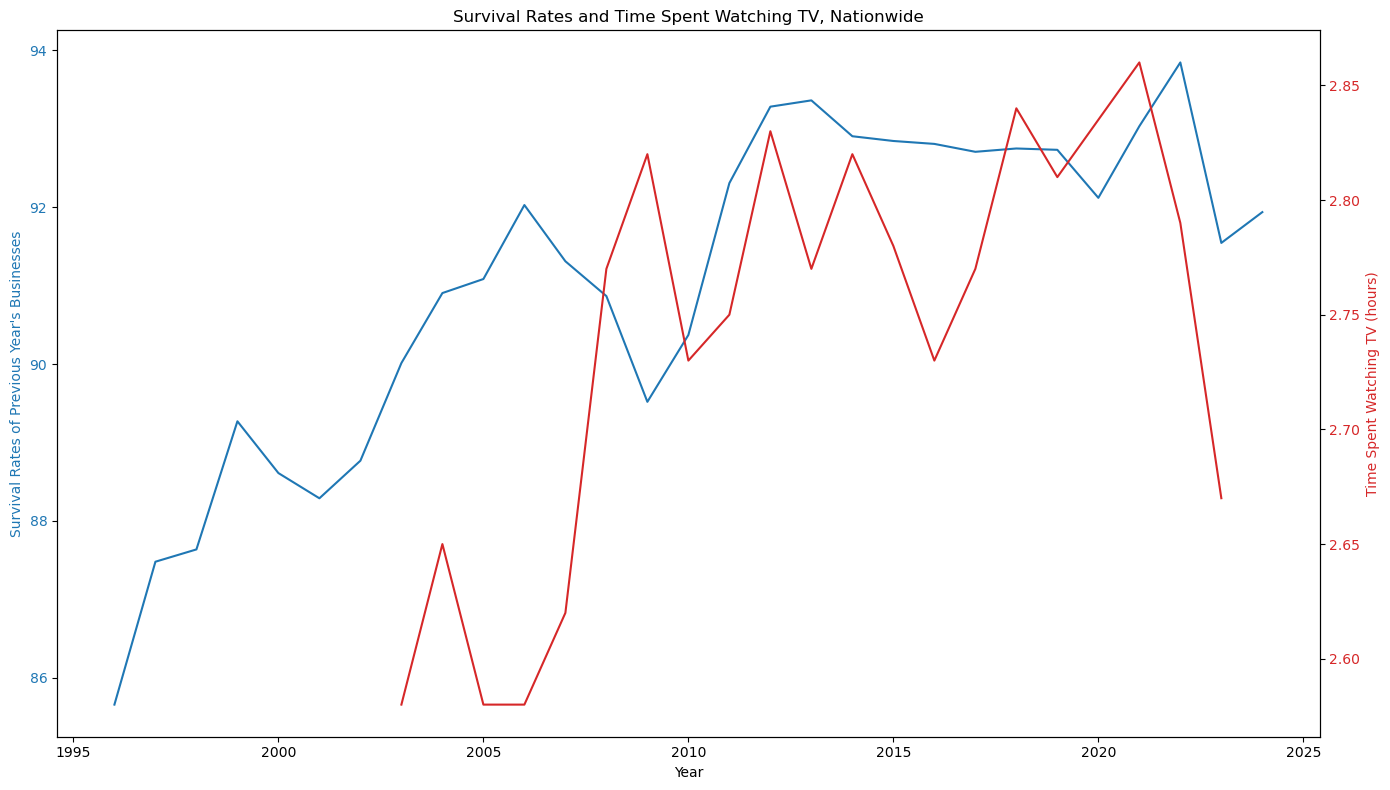

In [115]:
import matplotlib.pyplot as plt

# Filter the data for all states
survival_rates = survival_rates_grouped_nationwide
years = survival_rates.index.get_level_values('Year')

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the survival rates on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Survival Rates of Previous Year\'s Businesses', color=color)
ax1.plot(years, survival_rates.values, color=color, label='Survival Rates of Last Year\'s Surviving Businesses')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for the unemployment rates
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Time Spent Watching TV (hours)', color=color)
ax2.plot(time_spent_socializing.index.to_timestamp().year + 1, time_spent_socializing, color=color, label='Unemployment Rate')
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and show the plot
plt.title('Survival Rates and Time Spent Watching TV, Nationwide')
fig.tight_layout()
plt.show()
